In [1]:
import transformers
import torch
import datasets
import pdb

In [2]:
config = transformers.CONFIG_MAPPING['bert']().from_pretrained('bert-base-uncased')

In [3]:
bert = transformers.BertModel(config, add_pooling_layer=False).from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
corpus = datasets.load_dataset('bookcorpus',split='train')

Reusing dataset bookcorpus (/mounts/data/corp/huggingface/datasets/bookcorpus/plain_text/1.0.0/44662c4a114441c35200992bea923b170e6f13f2f0beb7c14e43759cec498700)


In [5]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

In [6]:
mini_tokenized = corpus.select(range(16)).map(lambda e: tokenizer(e['text'],truncation=True,padding='max_length',max_length=128),remove_columns=['text'])

Loading cached processed dataset at /mounts/data/corp/huggingface/datasets/bookcorpus/plain_text/1.0.0/44662c4a114441c35200992bea923b170e6f13f2f0beb7c14e43759cec498700/cache-2104a3e5d00ab1ee.arrow


In [7]:
mini_tokenized.set_format('torch')

In [8]:
mini_tokenized

Dataset({
    features: ['attention_mask', 'input_ids', 'token_type_ids'],
    num_rows: 16
})

In [56]:
output = bert(input_ids = mini_tokenized['input_ids'],
             attention_mask = mini_tokenized['attention_mask'],
             output_hidden_states=True,
#              output_attentions=True
             )

In [10]:
output.hidden_states[0].shape

torch.Size([16, 128, 768])

In [11]:
output_attn = output.last_hidden_state * mini_tokenized['attention_mask'].unsqueeze(2).expand_as(output.last_hidden_state)

In [12]:
output_attn.shape

torch.Size([16, 128, 768])

In [13]:
weight_p = torch.nn.Parameter(torch.rand(16,128))

In [14]:
weight = torch.rand(16,128)

In [15]:
out = torch.bmm(weight_p.unsqueeze(1),output.last_hidden_state)

In [16]:
torch.isclose((weight_p.unsqueeze(2).expand_as(output.last_hidden_state)*output.last_hidden_state).sum(1),
              out.squeeze())

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [17]:
class ParameterizedBertPooler(torch.nn.Module):
    def __init__(self,bert_layers,seq_len,batch_size):#args,config):
        super().__init__()
        
        self.bert_layers = bert_layers        
        self.weight_parameter = [torch.nn.Parameter(torch.rand(batch_size,1,seq_len)) for j in range(self.bert_layers)]
        
    def forward(self,bert_output,attention_mask):
        output = []
        start = 12
        end = 12-self.bert_layers
        j=0
        for i in range(start,end,-1): # go from 13 backwards
            hidden_state = bert_output.hidden_states[i]
            hidden_state_masked = hidden_state * attention_mask.unsqueeze(2).expand_as(hidden_state)
            out = torch.bmm(self.weight_parameter[j],hidden_state_masked) # batched dot product
            output.append(out.squeeze())
            j+=1 # weight_parameter counter
        
        return torch.stack(output).transpose(0,1) # swap batch and layer_dimension

In [18]:
class GeneralParameterizedPooler(torch.nn.Module):
    def __init__(self,num_layers,seq_len,batch_size):#args,config):
        super().__init__()
        
        self.num_layers = num_layers        
        self.weight_parameter = [torch.nn.Parameter(torch.rand(batch_size,1,seq_len)) for j in range(self.num_layers)]
        
    def forward(self,token_embeddings,attention_mask):
        assert len(token_embeddings)==self.num_layers, 'Number of embeddings must be the same as number of layers'
        output = []

        for i in range(self.num_layers):
            hidden_state = token_embeddings[i]
            hidden_state_masked = hidden_state * attention_mask.unsqueeze(2).expand_as(hidden_state)
            out = torch.bmm(self.weight_parameter[i],hidden_state_masked) # batched dot product
            output.append(out.squeeze())
        
        return torch.stack(output).transpose(0,1) # swap batch and layer_dimension

In [19]:
pooler = ParameterizedBertPooler(3,128,16)

In [20]:
pooler.weight_parameter[0].shape

torch.Size([16, 1, 128])

In [21]:
list(pooler.parameters())

[]

In [22]:
poolerG = GeneralParameterizedPooler(3,128,16)

In [23]:
pooled = poolerG(output.hidden_states[-3:],mini_tokenized['attention_mask'])

In [24]:
pooled.shape

torch.Size([16, 3, 768])

## new parameter

In [25]:
bs = 16
seq_len = 128
num_layers = 3

In [26]:
seq_param = [torch.nn.Parameter(torch.rand(seq_len)-0.5) for j in range(num_layers)]
layer_param = torch.nn.Parameter(torch.rand(num_layers))

In [27]:
seq_param[0].shape, layer_param.shape

(torch.Size([128]), torch.Size([3]))

In [28]:
output.hidden_states[0].shape

torch.Size([16, 128, 768])

In [33]:
seq_param[0].expand([bs,1,seq_len]).shape

torch.Size([16, 1, 128])

In [34]:
output.hidden_states[0].shape

torch.Size([16, 128, 768])

In [35]:
out=[torch.bmm(seq_param[i].expand([bs,1,seq_len]),output.hidden_states[i]).squeeze() for i in range(num_layers)]
out = torch.stack(out).transpose(0,1)

In [36]:
out.shape

torch.Size([16, 3, 768])

In [37]:
torch.bmm(layer_param.expand(bs,1,num_layers),out).squeeze().shape

torch.Size([16, 768])

In [38]:
class GeneralParameterizedPooler(torch.nn.Module):
    def __init__(self,num_layers,seq_len,batch_size):#args,config):
        super().__init__()
        
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.seq_weight_parameter = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(seq_len)-0.5) for j in range(self.num_layers)]) # random numbers between [-0.5,0.5]
        self.layer_weight_parameter = torch.nn.Parameter(torch.rand(num_layers)-0.5) # random numbers between [-0.5,0.5]
        
    def forward(self,token_embeddings,attention_mask):
        assert len(token_embeddings)==self.num_layers, 'Number of embeddings must be the same as number of layers'
        output = []

        for i in range(self.num_layers):
            hidden_state = token_embeddings[i]
            hidden_state_masked = hidden_state * attention_mask.unsqueeze(2).expand_as(hidden_state)
            weight_parameter = self.seq_weight_parameter[i].expand([self.batch_size,1,self.seq_len])
            out = torch.bmm(weight_parameter,hidden_state_masked) # batched dot product
            output.append(out.squeeze())
            
        layer_sentence_embeddings = torch.stack(output).transpose(0,1) # swap batch and layer_dimension
        
        model_sentence_embedding = torch.bmm(self.layer_weight_parameter.expand(bs,1,self.num_layers),layer_sentence_embeddings).squeeze()
        
        return model_sentence_embedding

In [39]:
poolerG = GeneralParameterizedPooler(3,128,16)

In [40]:
for param in poolerG.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128])


In [107]:
pooled = poolerG(output.hidden_states[-3:],mini_tokenized['attention_mask'])

In [109]:
pooled.shape

torch.Size([16, 768])

In [63]:
(torch.rand(100)-0.5).mean()

tensor(-0.0103)

In [68]:
poolerG.weight_parameter[1].mean()

tensor(0.0073, grad_fn=<MeanBackward0>)

In [119]:
conv1 = torch.nn.Conv1d(in_channels=1,out_channels=512,kernel_size=1)

In [120]:
conv1

Conv1d(1, 512, kernel_size=(1,), stride=(1,))

In [121]:
conv1(pooled.unsqueeze(1)).shape

torch.Size([16, 512, 768])

## shape error on backward pass

In [57]:
class GeneralParameterizedPooler(torch.nn.Module):
    def __init__(self,num_layers,seq_len,batch_size):#args,config):
        super().__init__()
        
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.seq_weight_parameter = torch.nn.ParameterList([torch.nn.Parameter(torch.rand(seq_len)-0.5) for j in range(self.num_layers)]) # random numbers between [-0.5,0.5]
        self.layer_weight_parameter = torch.nn.Parameter(torch.rand(num_layers)-0.5) # random numbers between [-0.5,0.5]
        
    def forward(self,token_embeddings,attention_mask):
        assert len(token_embeddings)==self.num_layers, 'Number of embeddings must be the same as number of layers'
        output = []

        for i in range(self.num_layers):
            hidden_state = token_embeddings[i]
            hidden_state_masked = hidden_state * attention_mask.unsqueeze(2).expand_as(hidden_state)
            weight_parameter = self.seq_weight_parameter[i].expand([self.batch_size,1,self.seq_len])
            out = torch.bmm(weight_parameter,hidden_state_masked) # batched dot product
            output.append(out.squeeze())
            
        layer_sentence_embeddings = torch.stack(output).transpose(0,1) # swap batch and layer_dimension
        
        model_sentence_embedding = torch.bmm(self.layer_weight_parameter.expand(self.batch_size,1,self.num_layers),layer_sentence_embeddings).squeeze()
        
        return {'sentence_embedding' : model_sentence_embedding}

    def get_sentence_embedding_dimension(self):
        return self.seq_len

In [58]:
poolerG = GeneralParameterizedPooler(3,128,16)

In [59]:
pooled = poolerG(output.hidden_states[-3:],mini_tokenized['attention_mask'])

In [60]:
loss = torch.nn.MSELoss()(pooled['sentence_embedding'],torch.rand_like(pooled['sentence_embedding']))

In [61]:
loss.backward()

In [44]:
loss.shape

torch.Size([16])

In [62]:
from torchviz import make_dot

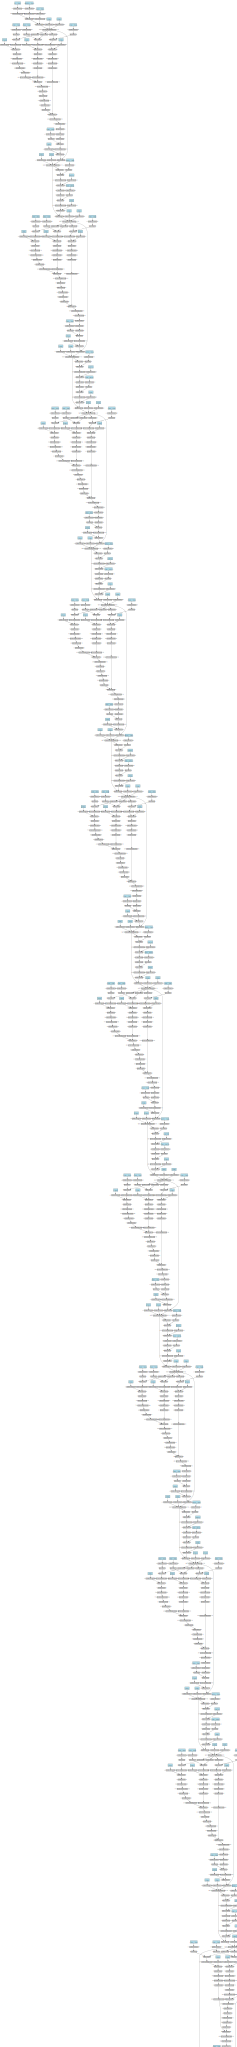

In [63]:
make_dot(loss)